# More Introduction to FCNN

## Learning Objectives
* Improve comfort with Pytorch
* Debugging a neural network

## Submission Instructions
**After completing the assignments, please upload a PDF output of this notebook.**

This is an individual assignment, but you may discuss your code with your neighbors.

## Dataset

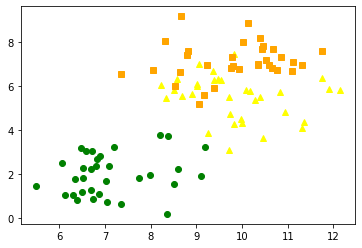

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
np.random.seed(4)
X, t = datasets.make_blobs(n_samples=100, centers=3, n_features=2, center_box=(0, 10))
plt.plot(X[:, 0][t == 0], X[:, 1][t == 0], marker='^',linestyle="None" ,color='yellow')
plt.plot(X[:, 0][t == 1], X[:, 1][t == 1], marker='s',linestyle="None",color='orange')
plt.plot(X[:, 0][t == 2], X[:, 1][t == 2], marker='o',linestyle="None",color='green')
plt.show()

## Assignment instructions
In this lab, you are provided with an implementation for a FCNN. You are also provided code to compute the precision, recall, and f1-score. I have removed some of the code in the second model, so it will not run without modifications.

Before coding anything, answer the following questions:
1. Which model is performing better between the first FCNN and k-nearest neighbor classifier? Explain your answer referencing precision, recall, and f1-score.
2. What observations can you make about the loss function?
3. What do the following lines do:
```
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()
```

Now that you've answered those questions, your mission is to improve the FCNN that is provided. I made a few changes and achieved the results you see at the end of the notebook. See if you can beat me!

In [97]:
from sklearn.model_selection import train_test_split
X_train, X_test, t_train, t_test = train_test_split(X, pd.get_dummies(t).values, test_size=0.33, random_state=42)
X_train2, X_val, t_train2, t_val = train_test_split(X_train, t_train, test_size=0.1, random_state=42)

In [98]:
import torch
import torch.optim as optim
import torch.nn as nn

def convert(data):
    return torch.tensor(data, requires_grad=False).type(torch.FloatTensor)

X_train = convert(X_train)
X_test = convert(X_test)
X_train2 = convert(X_train2)
X_val = convert(X_val)
t_test = convert(t_test)
t_train = convert(t_train)
t_train2 = convert(t_train2)
t_val = convert(t_val)

In [99]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, t_train)

KNeighborsClassifier(n_neighbors=3)

In [100]:
from sklearn.metrics import classification_report
y_fruit_pred = clf.predict(X_test)
print(classification_report(t_test, y_fruit_pred))

              precision    recall  f1-score   support

           0       0.70      0.50      0.58        14
           1       0.56      0.75      0.64        12
           2       1.00      1.00      1.00         7

   micro avg       0.70      0.70      0.70        33
   macro avg       0.75      0.75      0.74        33
weighted avg       0.71      0.70      0.69        33
 samples avg       0.70      0.70      0.70        33



In [102]:
class Net(nn.Module):
    def __init__(self,nhidden=2,nin=2):
        super(Net, self).__init__()
        self.nhidden = nhidden
        self.nin = nin
        hidden_nodes = []
        for h in range(nhidden):
            hidden_nodes.append(torch.nn.Parameter((torch.rand(self.nin+1,1)-.5)*2/torch.sqrt(torch.tensor(2)))) 
        self.hidden_nodes = nn.ParameterList(hidden_nodes)
        self.output = nn.Linear(nhidden, 3, bias=True)

    def forward(self, x):
        x = torch.cat((x,-torch.ones((x.shape[0],1))),axis=1)
        ys = []
        for h in self.hidden_nodes:
            ys.append(torch.matmul(x,h))
        y = torch.cat(ys,dim=1)
        y = torch.sigmoid(y) # end of the hidden layer forward step?
        y = torch.softmax(self.output(y),dim=1)
        return y
        
    def predict(self,x):
        return torch.round(self.forward(x))

In [121]:
import copy
net = Net()
criterion = nn.CrossEntropyLoss()
nepochs = 1000
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)
train_loss = []
val_loss = []
models = []
for epoch in range(nepochs):  # loop over the dataset multiple times
    inputs, labels = X_train2,t_train2

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    #print(inputs,outputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    train_loss.append(float(loss.data.numpy()))
    val_loss.append(float(criterion(net(X_val),t_val).data.numpy()))
    models.append(copy.deepcopy(net))

    # print statistics
    if epoch % 100 == 0:
        print(f'[{epoch + 1}] loss:',loss.data.numpy())

[1] loss: 1.1014731
[101] loss: 0.8511489
[201] loss: 0.83754224
[301] loss: 0.8471434
[401] loss: 1.1119075
[501] loss: 1.1116711
[601] loss: 1.0826472
[701] loss: 0.91952574
[801] loss: 0.90580857
[901] loss: 0.8984039


In [123]:
import altair
import altair as alt

source = pd.DataFrame({
  'epoch': np.arange(nepochs)+1,
  'training': train_loss,
  'validation': val_loss
})

source = source.melt(id_vars='epoch')
source.columns = ['epoch','loss','value']

alt.Chart(source).mark_line().encode(
    x='epoch',
    y='value',
    color='loss'
).interactive()

alt.Chart(...)

In [126]:
net = models[280]
y_fruit_pred = net.predict(X_test).detach().numpy()
print(classification_report(t_test, y_fruit_pred))

              precision    recall  f1-score   support

           0       0.75      0.21      0.33        14
           1       0.58      0.92      0.71        12
           2       0.78      1.00      0.88         7

   micro avg       0.66      0.64      0.65        33
   macro avg       0.70      0.71      0.64        33
weighted avg       0.69      0.64      0.59        33
 samples avg       0.64      0.64      0.64        33



/opt/tljh/user/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [132]:
class Net(nn.Module):
    pass

In [139]:
import copy
net = Net()
criterion = nn.CrossEntropyLoss()
nepochs = 1000
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)
train_loss = []
val_loss = []
models = []
for epoch in range(nepochs):  # loop over the dataset multiple times
    inputs, labels = X_train2,t_train2

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    #print(inputs,outputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    train_loss.append(float(loss.data.numpy()))
    val_loss.append(float(criterion(net(X_val),t_val).data.numpy()))
    models.append(copy.deepcopy(net))

    # print statistics
    if epoch % 100 == 0:
        print(f'[{epoch + 1}] loss:',loss.data.numpy())

[1] loss: 1.0989825
[101] loss: 0.47026002
[201] loss: 0.4604416
[301] loss: 0.41613376
[401] loss: 0.39464805
[501] loss: 0.3691707
[601] loss: 0.32917595
[701] loss: 2.0645216
[801] loss: 0.37421957
[901] loss: 0.3457958


In [140]:
import altair
import altair as alt

source = pd.DataFrame({
  'epoch': np.arange(nepochs)+1,
  'training': train_loss,
  'validation': val_loss
})

source = source.melt(id_vars='epoch')
source.columns = ['epoch','loss','value']

alt.Chart(source).mark_line().encode(
    x='epoch',
    y='value',
    color='loss'
).interactive()

alt.Chart(...)

In [141]:
net = models[650]
y_fruit_pred = net.predict(X_test).detach().numpy()
print(classification_report(t_test, y_fruit_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.61      0.92      0.73        12
           2       0.88      1.00      0.93         7

   micro avg       0.75      0.91      0.82        33
   macro avg       0.78      0.92      0.84        33
weighted avg       0.77      0.91      0.83        33
 samples avg       0.80      0.91      0.84        33

